Plotting resolution as function of neutrino properties for runE13.1...
ITS SIXTYEIGHT!
Calulating with statistic SIXTYEIGHT...
loading file 47
finished loading file 47 in 7.560374975204468s
loading file 48
finished loading file 48 in 7.721052408218384s
loading file 49
finished loading file 49 in 9.00999665260315s
Plotting nu_energy...
Plotting nu_azimuth...
Plotting nu_zenith...
Plotting nu_SNR...
Plotting angular resolution depending on properties for runE13.1!



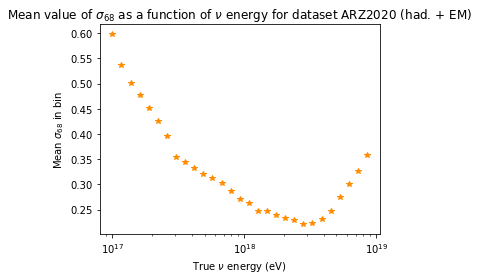

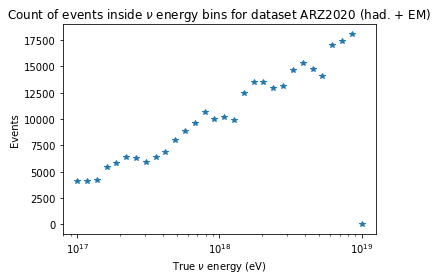

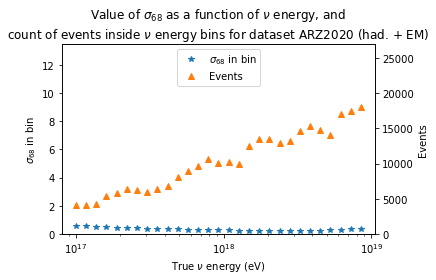

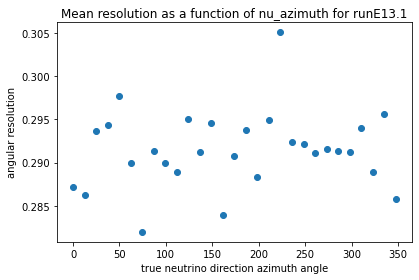

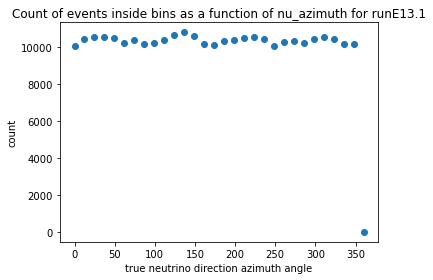

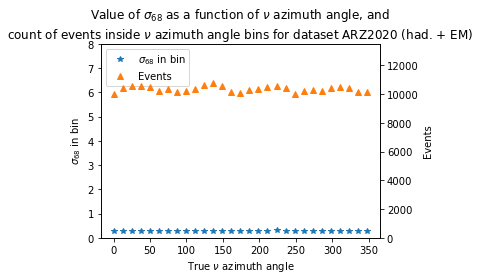

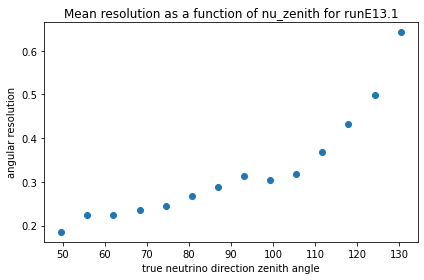

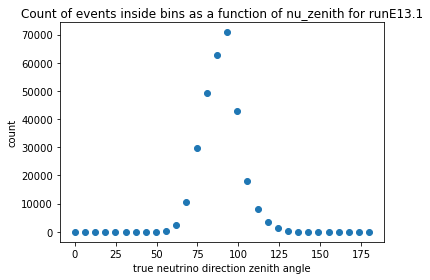

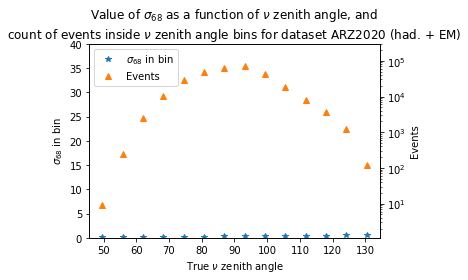

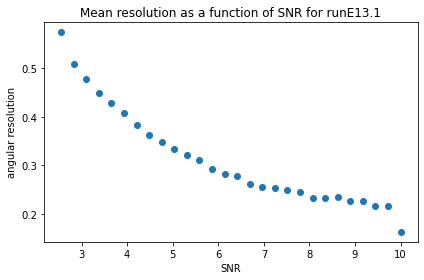

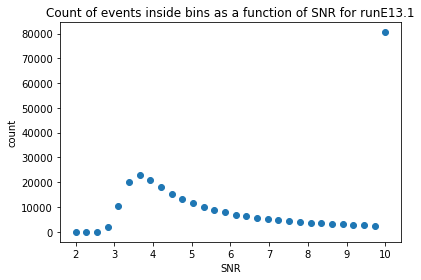

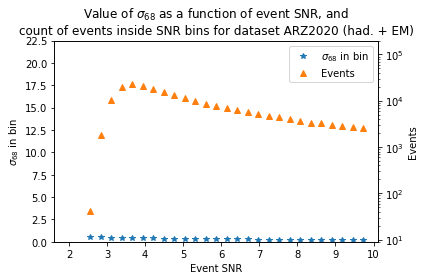

In [1]:

# Imports
import matplotlib.pyplot as plt
import numpy as np
from toolbox import get_pred_energy_diff_data, common_dir, calculate_percentage_interval
import sys
import argparse
import os
import time
import pickle
from NuRadioReco.utilities import units
from scipy import stats
from radiotools import stats as rtSTATS
from mpl_toolkits.mplot3d import Axes3D
from itertools import product, combinations
from radiotools import plthelpers as php
from tensorflow import keras
from radiotools import helper as hp
import datasets
# -------

# Loading data and label files and also other properties
def load_file_all_properties(i_file, norm=1e-6):
    t0 = time.time()
    print(f"loading file {i_file}", flush=True)

    # Load 500 MHz filter
    filt = np.load(f"{common_dir()}/bandpass_filters/500MHz_filter.npy")

    data = np.load(os.path.join(dataset.datapath, f"{dataset.data_filename}{i_file:04d}.npy"), allow_pickle=True)
    data = np.fft.irfft(np.fft.rfft(data, axis=-1) * filt, axis=-1)
    data = data[:, :, :, np.newaxis]
    
    labels_tmp = np.load(os.path.join(dataset.datapath, f"{dataset.label_filename}{i_file:04d}.npy"), allow_pickle=True)
    print(f"finished loading file {i_file} in {time.time() - t0}s")
    nu_zenith_data = np.array(labels_tmp.item()["nu_zenith"])
    nu_azimuth_data = np.array(labels_tmp.item()["nu_azimuth"])
    nu_direction_data = hp.spherical_to_cartesian(nu_zenith_data, nu_azimuth_data)

    nu_energy_data = np.array(labels_tmp.item()["nu_energy"])
    nu_flavor_data = np.array(labels_tmp.item()["nu_flavor"])
    shower_energy_data = np.array(labels_tmp.item()["shower_energy"])

    # check for nans and remove them
    idx = ~(np.isnan(data))
    idx = np.all(idx, axis=1)
    idx = np.all(idx, axis=1)
    idx = np.all(idx, axis=1)
    data = data[idx, :, :, :]
    data /= norm

    nu_zenith_data = nu_zenith_data[idx]
    nu_azimuth_data = nu_azimuth_data[idx]
    nu_direction_data = nu_direction_data[idx]
    nu_energy_data = nu_energy_data[idx]
    nu_flavor_data = nu_flavor_data[idx]
    shower_energy_data = shower_energy_data[idx]

    return data, nu_direction_data, nu_zenith_data, nu_azimuth_data, nu_energy_data, nu_flavor_data, shower_energy_data


def plot_same(x_data, ax1_data_y, ax2_data_y):
    print(f"Plotting {file_name}...")

    fig_same, ax1 = plt.subplots()

    ax1.set_xlabel(x_label)
    ax1.set_ylabel(ax1_y_label)

    # Set ax1 to high order to make it be in front so label is in front, and datapoints
    #ax1.set_zorder(1)

    if file_name == "nu_energy":
        ax1.set_xscale('log')

    # Remove last peices of data as their bins are weird for some azimuth
    if file_name == "nu_energy" or file_name == "nu_azimuth" or file_name == "nu_SNR":
        x_data = x_data[0:-1]
        ax1_data_y = ax1_data_y[0:-1]
        ax2_data_y = ax2_data_y[0:-1]

    # Remove any bins with zero events for nu_zenith
    if file_name == "nu_zenith":
        ind_count_not_0 = ax2_data_y != 0
        x_data = x_data[ind_count_not_0]
        ax1_data_y = ax1_data_y[ind_count_not_0]
        ax2_data_y = ax2_data_y[ind_count_not_0]

    lns1 = ax1.plot(x_data, ax1_data_y, "*", color=ax1_color, label = ax1_y_label)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel(ax2_y_label) # we already handled the x-label with ax1
    lns2 = ax2.plot(x_data, ax2_data_y, "^", color=ax2_color, label = ax2_y_label)

    # Set axis limits so they are same on all plots
    if file_name == "nu_energy":
        ax1.set_ylim(0, 13.5)
        ax2.set_ylim(0, 27000)
    elif file_name == "nu_SNR":
        ax2.set_yscale('log')
        ax1.set_ylim(0, 22.5)
        ax2.set_ylim(9, 2e5)
    elif file_name == "nu_zenith":
        ax2.set_yscale('log')
        ax1.set_ylim(0, 40)
        ax2.set_ylim(1.1, 300000)
    elif file_name == "nu_azimuth":
        ax1.set_ylim(0, 8)
        ax2.set_ylim(0, 13500)

    plt.title(plot_title)

    # added these three lines
    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=legend_loc)

    fig_same.tight_layout()  # otherwise the right y-label is slightly clipped

    #plt.subplots_adjust(top=0.88)
    if eps:
        fig_same.savefig(f"{plot_dir}/sigma68_{file_name}_same_{run_name}_statistic_{statistic_string}.eps", format="eps", bbox_inches='tight')
    else:
        fig_same.savefig(f"{plot_dir}/sigma68_{file_name}_same_{run_name}_statistic_{statistic_string}.png", bbox_inches='tight')


# # Parse arguments
# parser = argparse.ArgumentParser(description='Plot performance data')
# parser.add_argument('--eps', dest='eps', action='store_true', help="flag to image as .eps instead of .png")
# parser.add_argument('--median', dest='median', action='store_true', help="flag to do median instead of mean")
# parser.add_argument('--sixtyeight', dest='sixtyeight', action='store_true', help="flag to do 68 percent interval")
# parser.set_defaults(eps=False)
# parser.set_defaults(median=False)
# parser.set_defaults(sixtyeight=False)

plots_dir = "plots"

# args = parser.parse_args()
eps = False
median = False
sixtyeight = True

# run_names = ["runE12.1", "runE9.1", "runE13.1"]
# emission_models = ["Alvarez2009 (had.)", "ARZ2020 (had.)", "ARZ2020 (had. + EM)"]

# dataset_run = "E12.1"
# dataset_run = "E9.1"
dataset_run = "E13.1"


# Dataset setup
# Call Dataset(dataset_name, em, noise) with
#     dataset_name:
#         ALVAREZ (only had + noise) / ARZ
#     em:
#         True / False (default)
#     noise:
#         True (default) / False

if dataset_run == "E12.1":
    dataset_name = "ALVAREZ"
    dataset_em = False
    dataset_noise = True
if dataset_run == "E9.1":
    dataset_name = "ARZ"
    dataset_em = False
    dataset_noise = True
if dataset_run == "E13.1":
    dataset_name = "ARZ"
    dataset_em = True
    dataset_noise = True

dataset = datasets.Dataset(dataset_name, dataset_em, dataset_noise)

test_file_ids = dataset.test_file_ids
# datapath = dataset.datapath
# data_filename = dataset.data_filename
# label_filename = dataset.label_filename
# n_files = dataset.n_files
# n_files_val = dataset.n_files_val

plots_dir = "plots"



# Save the run name
run_name = f"run{dataset_run}"
if run_name == "runE12.1":
    emission_model = "Alvarez2009 (had.)"
elif run_name == "runE9.1":
    emission_model = "ARZ2020 (had.)"
elif run_name == "runE13.1":
    emission_model = "ARZ2020 (had. + EM)"

print(f"Plotting resolution as function of neutrino properties for {run_name}...")

# # Define 68 % interval statistic function
# def calculate_percentage_interval(angle_difference_data):
#     percentage=0.68
#     N = angle_difference_data.size
#     weights = np.ones(N)

#     angle = rtSTATS.quantile_1d(angle_difference_data, weights, percentage)

#     return angle


# See which statistic to calculate...
if median:
    print("ITS MEDIAN!")
    statistic = "median"
    statistic_string = "Median"
# else:
#     statistic = "mean"
#     statistic_string = "Mean"

if sixtyeight:
    print("ITS SIXTYEIGHT!")
    statistic = calculate_percentage_interval
    statistic_string = "SIXTYEIGHT"

print(f"Calulating with statistic {statistic_string}...")


# Make sure plots folder exists
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

plot_dir = f"plots/{run_name}_plots"

# Make sure folder inside plot_folder exists for the plots
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# # Make sure predicted file exists, otherwise run evaluator
# prediction_file = f'{plots_dir}/model.{run_name}.h5_predicted.pkl'
# if not os.path.isfile(prediction_file):
#     print("Prediction file does not exist, running evaluator...")
#     os.system(f"python evaluator.py")

# Load test file data
    # Load first file
data, nu_direction, nu_zenith, nu_azimuth, nu_energy, nu_flavor, shower_energy = load_file_all_properties(test_file_ids[0])

    # Then load rest of files
if len(test_file_ids) > 1:
    for test_file_id in test_file_ids:
        if test_file_id != test_file_ids[0]:
            data_tmp, nu_direction_tmp, nu_zenith_tmp, nu_azimuth_tmp, nu_energy_tmp, nu_flavor_tmp, shower_energy_tmp = load_file_all_properties(test_file_id)

            data = np.concatenate((data, data_tmp))
            nu_direction = np.concatenate((nu_direction, nu_direction_tmp))
            nu_zenith = np.concatenate((nu_zenith, nu_zenith_tmp))
            nu_azimuth = np.concatenate((nu_azimuth, nu_azimuth_tmp))
            nu_energy = np.concatenate((nu_energy, nu_energy_tmp))
            nu_flavor = np.concatenate((nu_flavor, nu_flavor_tmp))
            shower_energy = np.concatenate((shower_energy, shower_energy_tmp))


# Get angle difference data
# angle_difference_data is actually energy difference data
angle_difference_data = get_pred_energy_diff_data(run_name)

sigma_68_string = "_{68}"

# --------- Energy plotting ---------
# Create figure
fig_energy = plt.figure()

# Calculate binned statistics
ax = fig_energy.add_subplot(1, 1, 1)
nu_energy_bins = np.logspace(np.log10(1e17),np.log10(10**19), 30)
nu_energy_bins_with_one_extra = np.append(np.logspace(np.log10(1e17),np.log10(10**19), 30), [1e20])
binned_resolution_nu_energy = stats.binned_statistic(nu_energy, angle_difference_data, bins = nu_energy_bins_with_one_extra, statistic=statistic)[0]

ax.plot(nu_energy_bins, binned_resolution_nu_energy, "*", color="darkorange")
# ax.set_ylim(0, 0.4)
ax.set_xlabel(r"True $\nu$ energy (eV)")
ax.set_ylabel(r"Mean $\sigma_{68}$ in bin")
ax.set_xscale('log')


# ax = fig_energy.add_subplot(1, 2, 2)
# ax.plot(nu_energy, angle_difference_data, 'o')
# ax.set_xscale('log')


plt.title(fr"Mean value of $\sigma{sigma_68_string}$ as a function of $\nu$ energy for dataset {emission_model}")
fig_energy.tight_layout()
fig_energy.savefig(f"{plot_dir}/{statistic_string}_resolution_nu_energy_{run_name}.png")
# ___________________________________

# --------- Energy count plotting ---------
# Create figure
fig_energy_count = plt.figure()

# Calculate binned statistics
ax = fig_energy_count.add_subplot(1, 1, 1)
binned_resolution_nu_energy_count = stats.binned_statistic(nu_energy, angle_difference_data, bins = nu_energy_bins_with_one_extra, statistic = "count")[0]
 
ax.plot(nu_energy_bins, binned_resolution_nu_energy_count, "*")
# ax.set_ylim(0, 0.4)
ax.set_xlabel(r"True $\nu$ energy (eV)")
ax.set_ylabel("Events")
ax.set_xscale('log')

plt.title(fr"Count of events inside $\nu$ energy bins for dataset {emission_model}")
fig_energy_count.tight_layout()
fig_energy_count.savefig(f"{plot_dir}/{statistic_string}_resolution_nu_energy_count_{run_name}.png")
# ___________________________________

# Energy resolution & count on same axis
# Constants:
ax1_color = 'tab:blue'
ax2_color = 'tab:orange'
x_label = r"True $\nu$ energy (eV)"
ax1_y_label = fr"$\sigma{sigma_68_string}$ in bin"
ax2_y_label = "Events"

x_data = nu_energy_bins
ax1_data_y = binned_resolution_nu_energy
ax2_data_y = binned_resolution_nu_energy_count

file_name = "nu_energy"
plot_title_1 = fr"Value of $\sigma{sigma_68_string}$ as a function of $\nu$ energy"
plot_title_2 = fr"count of events inside $\nu$ energy bins for dataset {emission_model}"
plot_title = plot_title_1 + ", and\n" + plot_title_2
legend_loc = "upper center"
# Constants END

plot_same(x_data, ax1_data_y, ax2_data_y)
# ______________________________________


# --------- Azimuth plotting ---------
# Create figure
fig_azimuth = plt.figure()

# Calculate binned statistics
ax = fig_azimuth.add_subplot(1, 1, 1)
nu_azimuth_bins = np.linspace(0,np.deg2rad(360), 30)
nu_azimuth_bins_with_one_extra = np.append(np.linspace(0,np.deg2rad(360), 30), 2*np.pi+1)
binned_resolution_nu_azimuth = stats.binned_statistic(nu_azimuth, angle_difference_data, bins = nu_azimuth_bins_with_one_extra, statistic=statistic)[0]

ax.plot(nu_azimuth_bins / units.deg, binned_resolution_nu_azimuth, "o")
# ax.set_ylim(0, 0.4)
ax.set_xlabel("true neutrino direction azimuth angle")
ax.set_ylabel("angular resolution")


plt.title(f"Mean resolution as a function of nu_azimuth for {run_name}")
fig_azimuth.tight_layout()
fig_azimuth.savefig(f"{plot_dir}/{statistic_string}_resolution_nu_azimuth_{run_name}.png")
# ___________________________________

# --------- Azimuth count plotting ---------
# Create figure
fig_azimuth_count = plt.figure()

# Calculate binned statistics
ax = fig_azimuth_count.add_subplot(1, 1, 1)

binned_resolution_nu_azimuth_count = stats.binned_statistic(nu_azimuth, angle_difference_data, bins = nu_azimuth_bins_with_one_extra, statistic = "count")[0]

ax.plot(nu_azimuth_bins / units.deg, binned_resolution_nu_azimuth_count, "o")
# ax.set_ylim(0, 0.4)
ax.set_xlabel("true neutrino direction azimuth angle")
ax.set_ylabel("count")


plt.title(f"Count of events inside bins as a function of nu_azimuth for {run_name}")
fig_azimuth_count.tight_layout()
fig_azimuth_count.savefig(f"{plot_dir}/{statistic_string}_resolution_nu_azimuth_count_{run_name}.png")
# ___________________________________

# Azimuth resolution & count on same axis
# Constants:
x_label = r"True $\nu$ azimuth angle"
ax1_y_label = fr"$\sigma{sigma_68_string}$ in bin"
ax2_y_label = "Events"

x_data = nu_azimuth_bins / units.deg
ax1_data_y = binned_resolution_nu_azimuth
ax2_data_y = binned_resolution_nu_azimuth_count

file_name = "nu_azimuth"
plot_title_1 = fr"Value of $\sigma{sigma_68_string}$ as a function of $\nu$ azimuth angle"
plot_title_2 = fr"count of events inside $\nu$ azimuth angle bins for dataset {emission_model}"
plot_title = plot_title_1 + ", and\n" + plot_title_2
legend_loc = "upper left"
# Constants END

plot_same(x_data, ax1_data_y, ax2_data_y)
# ______________________________________



# --------- Zenith plotting ---------
# Create figure
fig_zenith = plt.figure()

# Calculate binned statistics
ax = fig_zenith.add_subplot(1, 1, 1)
nu_zenith_bins = np.linspace(0,np.pi, 30)
nu_zenith_bins_with_one_extra = np.append(np.linspace(0,np.pi, 30), np.pi+1)
binned_resolution_nu_zenith = stats.binned_statistic(nu_zenith, angle_difference_data, bins = nu_zenith_bins_with_one_extra, statistic=statistic)[0]

ax.plot(nu_zenith_bins / units.deg, binned_resolution_nu_zenith, "o")
# ax.set_ylim(0, 0.4)
ax.set_xlabel("true neutrino direction zenith angle")
ax.set_ylabel("angular resolution")

plt.title(f"Mean resolution as a function of nu_zenith for {run_name}")
fig_zenith.tight_layout()
fig_zenith.savefig(f"{plot_dir}/{statistic_string}_resolution_nu_zenith_{run_name}.png")
# ___________________________________

# --------- Zenith count plotting ---------
# Create figure
fig_zenith_count = plt.figure()

# Calculate binned statistics
ax = fig_zenith_count.add_subplot(1, 1, 1)
binned_resolution_nu_zenith_count = stats.binned_statistic(nu_zenith, angle_difference_data, bins = nu_zenith_bins_with_one_extra, statistic = "count")[0]

ax.plot(nu_zenith_bins / units.deg, binned_resolution_nu_zenith_count, "o")
# ax.set_ylim(0, 0.4)
ax.set_xlabel("true neutrino direction zenith angle")
ax.set_ylabel("count")

plt.title(f"Count of events inside bins as a function of nu_zenith for {run_name}")
fig_zenith_count.tight_layout()
fig_zenith_count.savefig(f"{plot_dir}/{statistic_string}_resolution_nu_zenith_count_{run_name}.png")
# ___________________________________

# Zenith resolution & count on same axis
# Constants:
x_label = r"True $\nu$ zenith angle"
ax1_y_label = fr"$\sigma{sigma_68_string}$ in bin"
ax2_y_label = "Events"

x_data = nu_zenith_bins / units.deg
ax1_data_y = binned_resolution_nu_zenith
ax2_data_y = binned_resolution_nu_zenith_count

file_name = "nu_zenith"
plot_title_1 = fr"Value of $\sigma{sigma_68_string}$ as a function of $\nu$ zenith angle"
plot_title_2 = fr"count of events inside $\nu$ zenith angle bins for dataset {emission_model}"
plot_title = plot_title_1 + ", and\n" + plot_title_2
legend_loc = "upper left"
# Constants END

plot_same(x_data, ax1_data_y, ax2_data_y)
# ______________________________________



# --------- SNR plotting ---------
max_LPDA = np.max(np.max(np.abs(data[:, 0:4, :]), axis=2), axis=1)

# print(max_LPDA[:, 0])
# index_max_LPDA_big = max_LPDA[:, 0] * 10 > 300
# print(max_LPDA.index(index_max_LPDA_big[0]))


# print("data.shape:", data.shape)
# #print("data:", data)

# print("data[:, :, 0:4].shape", data[:, 0:4, :].shape)
# #print("data[:, :, 0:4]", data[:, 0:4, :])

# print("np.abs(data[:, :, 0:4]).shape", np.abs(data[:, 0:4, :]).shape)
# #print("np.abs(data[:, :, 0:4])", np.abs(data[:, 0:4, :]))

# print("np.max(np.abs(data[:, :, 0:4]), axis=1).shape:", np.max(np.abs(data[:, 0:4, :]), axis=2).shape)
# #print("np.max(np.abs(data[:, :, 0:4]), axis=1):", np.max(np.abs(data[:, 0:4, :]), axis=1))

# print("np.max(np.max(np.abs(data[:, :, 0:4]), axis=1), axis=1).shape:", np.max(np.max(np.abs(data[:, 0:4, :]), axis=2), axis=1).shape)
# #print("np.max(np.max(np.abs(data[:, :, 0:4]), axis=1), axis=1):", np.max(np.max(np.abs(data[:, 0:4, :]), axis=1), axis=1))

# Create figure
fig_SNR = plt.figure()

# Calculate binned statistics
ax = fig_SNR.add_subplot(1, 1, 1)

SNR_means = np.linspace(2, 10, 30)
SNR_bins = np.append(np.linspace(2, 10, 30), 10000)

#SNR_means = np.arange(0.5, 300.5, 1)
#SNR_bins = np.append(np.arange(0, 300, 1), [10000])

binned_resolution_SNR_mean = stats.binned_statistic(max_LPDA[:, 0] / 10., angle_difference_data, bins=SNR_bins, statistic=statistic)[0]

ax.plot(SNR_means, binned_resolution_SNR_mean, "o")
# ax.set_ylim(0, 0.4)
ax.set_xlabel("SNR")
ax.set_ylabel("angular resolution")

plt.title(f"Mean resolution as a function of SNR for {run_name}")
fig_SNR.tight_layout()
fig_SNR.savefig(f"{plot_dir}/{statistic_string}_resolution_SNR_{run_name}.png")
# ___________________________________

# --------- SNR count plotting ---------
# Create figure
fig_SNR_count = plt.figure()

# Calculate binned statistics
ax = fig_SNR_count.add_subplot(1, 1, 1)

binned_resolution_SNR_mean_count = stats.binned_statistic(max_LPDA[:, 0] / 10., angle_difference_data, bins=SNR_bins, statistic = "count")[0]

ax.plot(SNR_means, binned_resolution_SNR_mean_count, "o")
# ax.set_ylim(0, 0.4)
ax.set_xlabel("SNR")
ax.set_ylabel("count")

plt.title(f"Count of events inside bins as a function of SNR for {run_name}")
fig_SNR_count.tight_layout()
fig_SNR_count.savefig(f"{plot_dir}/{statistic_string}_resolution_SNR_count_{run_name}.png")
# ___________________________________


# SNR resolution & count on same axis
# Constants:
x_label = r"Event SNR"
ax1_y_label = fr"$\sigma{sigma_68_string}$ in bin"
ax2_y_label = "Events"

x_data = SNR_means
ax1_data_y = binned_resolution_SNR_mean
ax2_data_y = binned_resolution_SNR_mean_count

file_name = "nu_SNR"
plot_title_1 = fr"Value of $\sigma{sigma_68_string}$ as a function of event SNR"
plot_title_2 = fr"count of events inside SNR bins for dataset {emission_model}"
plot_title = plot_title_1 + ", and\n" + plot_title_2
legend_loc = "upper right"
# Constants END

plot_same(x_data, ax1_data_y, ax2_data_y)
# ______________________________________


# Save plotting data for plotting all at once
with open(f'{plots_dir}/plotdata_{statistic_string}_{run_name}.npy', 'wb') as f:
    np.save(f, nu_energy_bins)
    np.save(f, binned_resolution_nu_energy)
    np.save(f, binned_resolution_nu_energy_count)

    np.save(f, nu_azimuth_bins / units.deg)
    np.save(f, binned_resolution_nu_azimuth)
    np.save(f, binned_resolution_nu_azimuth_count)

    np.save(f, nu_zenith_bins / units.deg)
    np.save(f, binned_resolution_nu_zenith)
    np.save(f, binned_resolution_nu_zenith_count)

    np.save(f, SNR_means)
    np.save(f, binned_resolution_SNR_mean)
    np.save(f, binned_resolution_SNR_mean_count)

print(f"Plotting angular resolution depending on properties for {run_name}!")
print("")